In [1]:
import numpy as np
from core.audio_io import load_audio, play_audio
from core.mixing import mix_sources_multichannel, error_signal
from core.visualization import plot_spectrogram
from separation.fastica_sep import fastica_separate

s1, fs = load_audio("data/speech/speaker1.wav")
s2, _  = load_audio("data/speech/speaker2.wav")

# Mix
A = np.array([[1.0, 0.3],
              [0.3, 1.0]])
X = mix_sources_multichannel([s1, s2], A)
x1, x2 = X[0], X[1]

# ICA
S_hat = fastica_separate(X, n_sources=2)
s1_hat, s2_hat = S_hat[0], S_hat[1]

# Listen
play_audio(x1, fs)



In [2]:
play_audio(s1_hat, fs)

In [3]:
play_audio(s1, fs)

In [4]:
play_audio(s2_hat, fs)

In [5]:
from evaluation.benchmarking import evaluate_method, print_results
from core.audio_io import normalize

s1, fs = load_audio("data/speech/speaker1.wav")
s2, _  = load_audio("data/speech/speaker2.wav") 
s1 = normalize(s1)
s2 = normalize(s2)
# Mix
A = np.array([[1.0, 0.91],
              [0.83, 1.0]])

X = mix_sources_multichannel([s1, s2], A)

X_noisy = X + 0.01 * np.random.randn(*X.shape)
x1, x2 = X_noisy[0], X_noisy[1]

# ICA
S_hat = fastica_separate(X_noisy, n_sources=2)
s1_hat, s2_hat = S_hat[0], S_hat[1]

s1 = normalize(s1)
s2_hat = normalize(s2_hat)

# Listen
play_audio(x2, fs)

In [6]:
corr = np.corrcoef(s1, s1_hat)[0,1]
print(corr)

0.17478486350282277


In [7]:
play_audio(s1_hat, fs)

In [8]:
res_ica = evaluate_method(s1, x1, s1_hat)
print_results(res_ica)

SNR_in (dB)           : -2.566
SNR_out (dB)          : -22.430
SNR_improvement (dB)  : -19.863
Segmental_SNR (dB)    : -26.925
MSE                   : 0.979
LSD                   : 44.380


# Real-Life Data ICA Test 

In [9]:
import numpy as np
from enhancement.wiener_static import wiener_filter_static
from scipy.signal import correlate
from separation.fd_ica import fd_ica_separate


s1, fs = load_audio("data/real_recordings/ica_s1_sync.wav")
s2, _ = load_audio("data/real_recordings/ica_s2_sync.wav")

corr = correlate(s1, s2, mode="full")
lag = np.argmax(corr) - (len(s1) - 1)
print("Estimated delay (samples):", lag)
print("Delay (ms):", lag / fs * 1000)

if lag > 0:
    s1 = s1[lag:]
    s2 = s2[:len(s1)]
elif lag < 0:
    s2 = s2[-lag:]
    s1 = s1[:len(s2)]


Estimated delay (samples): -87
Delay (ms): -5.4375


In [10]:
X_real = np.vstack([s1, s2])  
# ICA
Sreal_hat = fastica_separate(X_real, n_sources=2)
sr1_hat, sr2_hat = Sreal_hat[0], Sreal_hat[1]


# Listen
play_audio(s1, fs)

In [11]:
play_audio(sr1_hat, fs)

In [12]:
corr = correlate(s1, s2, mode="full")
lag = np.argmax(corr) - (len(s1) - 1)
print("Estimated delay (samples):", lag)
print("Delay (ms):", lag / fs * 1000)

Estimated delay (samples): 0
Delay (ms): 0.0


# Evaluation of ICA

=== ICA Synthetic Evaluation ===
Correlation (Speech 1): 0.963
Correlation (Speech 2): 0.993
Leakage into Speech 1 (dB): -6.38
Leakage into Speech 2 (dB): 6.38


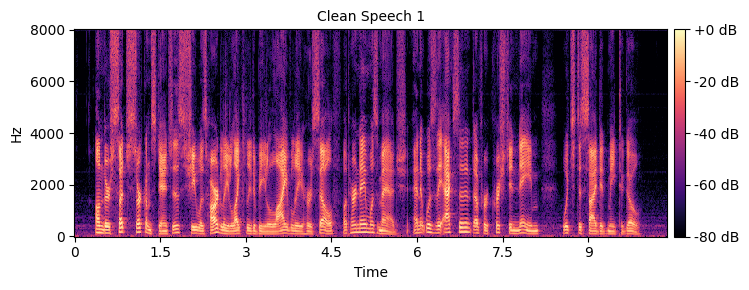

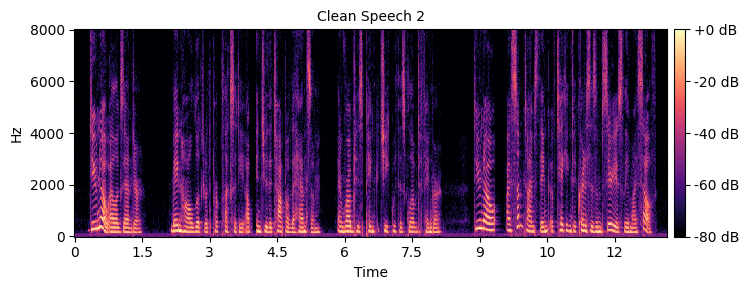

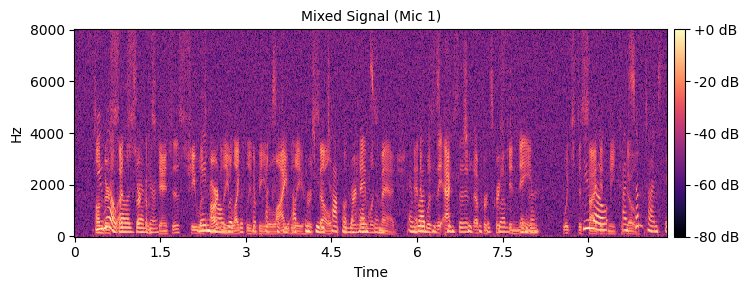

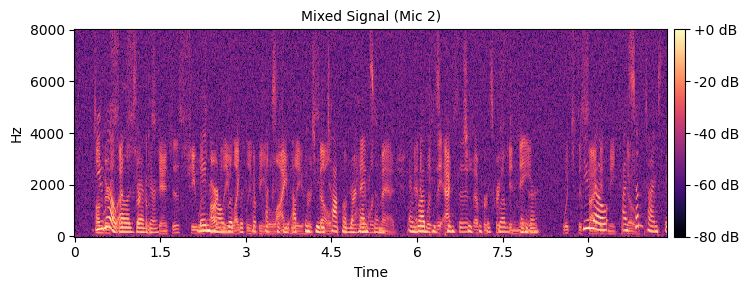

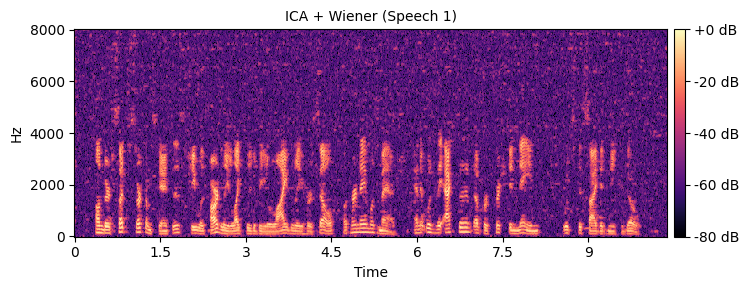

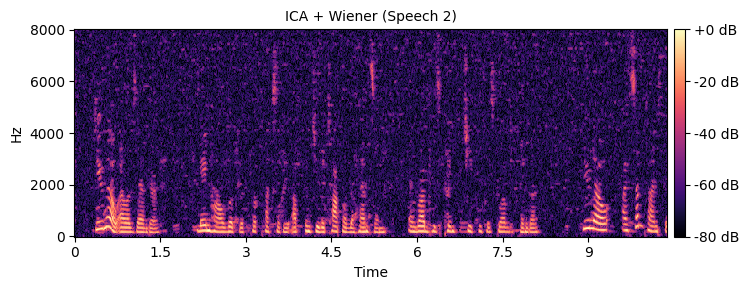

In [ ]:
import numpy as np

from core.audio_io import load_audio, play_audio, normalize
from core.mixing import mix_sources_multichannel
from separation.fastica_sep import fastica_separate
from enhancement.wiener_static import wiener_filter_static   # your static Wiener
from core.visualization import plot_spectrogram


# --------------------------------------------------
# Small helpers (no DSP re-implementation)
# --------------------------------------------------

def align(x, y):
    L = min(len(x), len(y))
    return x[:L], y[:L]


def correlation_coeff(s, s_hat):
    s, s_hat = align(s, s_hat)
    s -= np.mean(s)
    s_hat -= np.mean(s_hat)
    return np.dot(s, s_hat) / (np.linalg.norm(s) * np.linalg.norm(s_hat) + 1e-12)


def leakage_energy(target_hat, interferer_hat):
    target_hat, interferer_hat = align(target_hat, interferer_hat)
    return 10 * np.log10(
        np.sum(interferer_hat**2) / (np.sum(target_hat**2) + 1e-12)
    )


# --------------------------------------------------
# Load clean speech
# --------------------------------------------------

s1, fs = load_audio("data/speech/speaker1.wav")
s2, _  = load_audio("data/speech/speaker2.wav")

s1 = normalize(s1)
s2 = normalize(s2)

# --------------------------------------------------
# Mixing + sensor noise
# --------------------------------------------------

A = np.array([[1.0, 0.78],
              [0.82, 1.0]])

X = mix_sources_multichannel([s1, s2], A)

# Add sensor / non-ideal noise
X_noisy = X + 0.01 * np.random.randn(*X.shape)

x1, x2 = X_noisy[0], X_noisy[1]

# --------------------------------------------------
# ICA separation
# --------------------------------------------------

S_hat = fastica_separate(X_noisy, n_sources=2)
s1_hat, s2_hat = S_hat[0], S_hat[1]

# --------------------------------------------------
# Post-ICA Static Wiener Filtering
# --------------------------------------------------

s1_hat = wiener_filter_static(s1_hat, fs)
s2_hat = wiener_filter_static(s2_hat, fs)

s1_hat = normalize(s1_hat)
s2_hat = normalize(s2_hat)

# --------------------------------------------------
# Evaluation (Synthetic Ground Truth Available)
# --------------------------------------------------

corr_s1 = correlation_coeff(s1, -s2_hat)
corr_s2 = correlation_coeff(s2, -s1_hat)

leak_s1 = leakage_energy(s1_hat, s2_hat)
leak_s2 = leakage_energy(s2_hat, s1_hat)

print("=== ICA Synthetic Evaluation ===")
print(f"Correlation (Speech 1): {corr_s1:.3f}")
print(f"Correlation (Speech 2): {corr_s2:.3f}")
print(f"Leakage into Speech 1 (dB): {leak_s1:.2f}")
print(f"Leakage into Speech 2 (dB): {leak_s2:.2f}")

# --------------------------------------------------
# Optional visualization
# --------------------------------------------------
s1, s2 = align(s1, s2)
plot_spectrogram(s1, fs, title="Clean Speech 1")
plot_spectrogram(s2, fs, title="Clean Speech 2")
plot_spectrogram(x1, fs, title="Mixed Signal (Mic 1)")
plot_spectrogram(x2, fs, title="Mixed Signal (Mic 2)")
plot_spectrogram(s2_hat, fs, title="ICA + Wiener (Speech 1)")
plot_spectrogram(s1_hat, fs, title="ICA + Wiener (Speech 2)")


In [14]:
play_audio(x1, fs) # microfon 1 with noise

In [15]:
play_audio(s1, fs) # speaker 1 clean

In [16]:
play_audio(s2_hat, fs) # speaker 1 filtered

In [17]:
play_audio(s2, fs) # speaker 2 clean

In [18]:
play_audio(s1_hat, fs) # speaker 2 filtered